In [1]:
import os

root_dir = os.path.abspath('..')
data_dir = os.path.join(root_dir, 'data/data')
save_path = os.path.join(data_dir, 'assets_info.csv')

train_path = os.path.join(data_dir, 'X_train.csv')
test_path = os.path.join(data_dir, 'X_test.csv')

## Clusterization

I'll try 2 approaches:
* KMeans + Euclidian distance (by tsfel)
* KMeans + DTW (by tslearn)

Since both approaches yield some interesting results, I'll extract features from both and combine them.

In [2]:
import pandas as pd
import numpy as np

from tslearn.clustering import TimeSeriesKMeans

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
X_train = pd.read_csv(train_path)
X_test = pd.read_csv(test_path)

In [4]:
X_train.head(1)

value_0   value_1   value_2   value_3   value_4   value_5  value_6  \
0  0.298922  0.433164  0.282143  0.500285  0.500285  0.600968  0.70165   

    value_7   value_8   value_9  ...  value_200  value_201  value_202  \
0  0.567406  0.600968  0.600968  ...  -0.909258  -0.744475  -0.540092   

   value_203  value_204  value_205  value_206  value_207  value_208  value_209  
0  -0.573652  -0.808577  -0.238382  -0.875698  -0.851534  -0.842137    -1.0435  

[1 rows x 210 columns]

#### KMeans Clustering

100%|██████████| 6/6 [19:51<00:00, 198.51s/it]


Text(0.5, 1.0, 'Elbow Method')

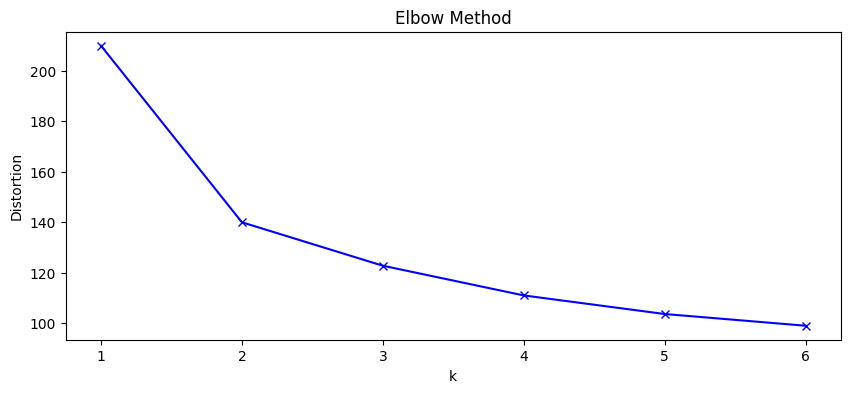

In [5]:
from tqdm import tqdm

distortions = []
K = range(1, 7)
for k in tqdm(K):
    kmeanModel = TimeSeriesKMeans(n_clusters=k, metric="euclidean", n_jobs=6, max_iter=25)
    kmeanModel.fit(X_train)
    distortions.append(kmeanModel.inertia_)

plt.figure(figsize=(10,4))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('Elbow Method')

Though I think that it's more correct to take 3 clusters by elbow method, I'll take 4 clusters to have more patterns.

In [5]:
n_clusters = 4
ts_kmeans = TimeSeriesKMeans(n_clusters=n_clusters, metric="euclidean", n_jobs=3, max_iter=25)
ts_kmeans.fit(X_train)

kmeans_cluster = ts_kmeans.predict(X_train)

/home/coder/.local/lib/rolos-python/site-packages/tslearn/utils/utils.py:90: UserWarning: 2-Dimensional data passed. Assuming these are 108298 1-dimensional timeseries
  warnings.warn(


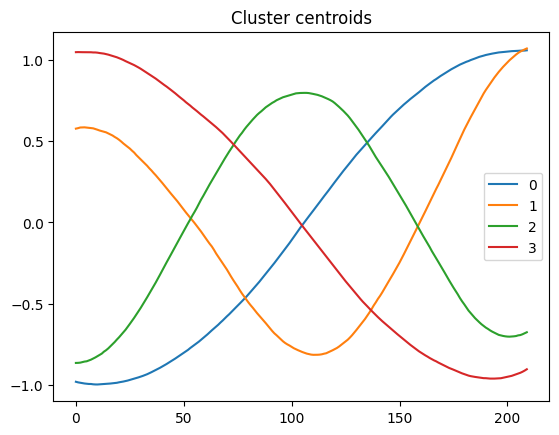

In [7]:
for cluster_number in range(n_clusters):
    plt.plot(ts_kmeans.cluster_centers_[cluster_number, :, 0].T, label=cluster_number)
plt.title("Cluster centroids")
plt.legend()

In [12]:
def plot_cluster_tickers(current_cluster):
    fig, ax = plt.subplots(
        int(np.ceil(current_cluster.shape[0]/4)),
        4,
        figsize=(15, 3*int(np.ceil(current_cluster.shape[0]/4)))
    )
    fig.autofmt_xdate(rotation=45)
    ax = ax.reshape(-1)

    for index, (_, row) in enumerate(current_cluster.iterrows()):
        ax[index].plot(row.values)
        plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

def print_clusters(n_clusters, X_train, cluster_ids):
    for cluster in range(n_clusters):
        print("=================================================================================")
        print(f"                          Cluster number: {cluster}")
        print("=================================================================================")
        plot_cluster_tickers(X_train[cluster_ids == cluster])


                          Cluster number: 0


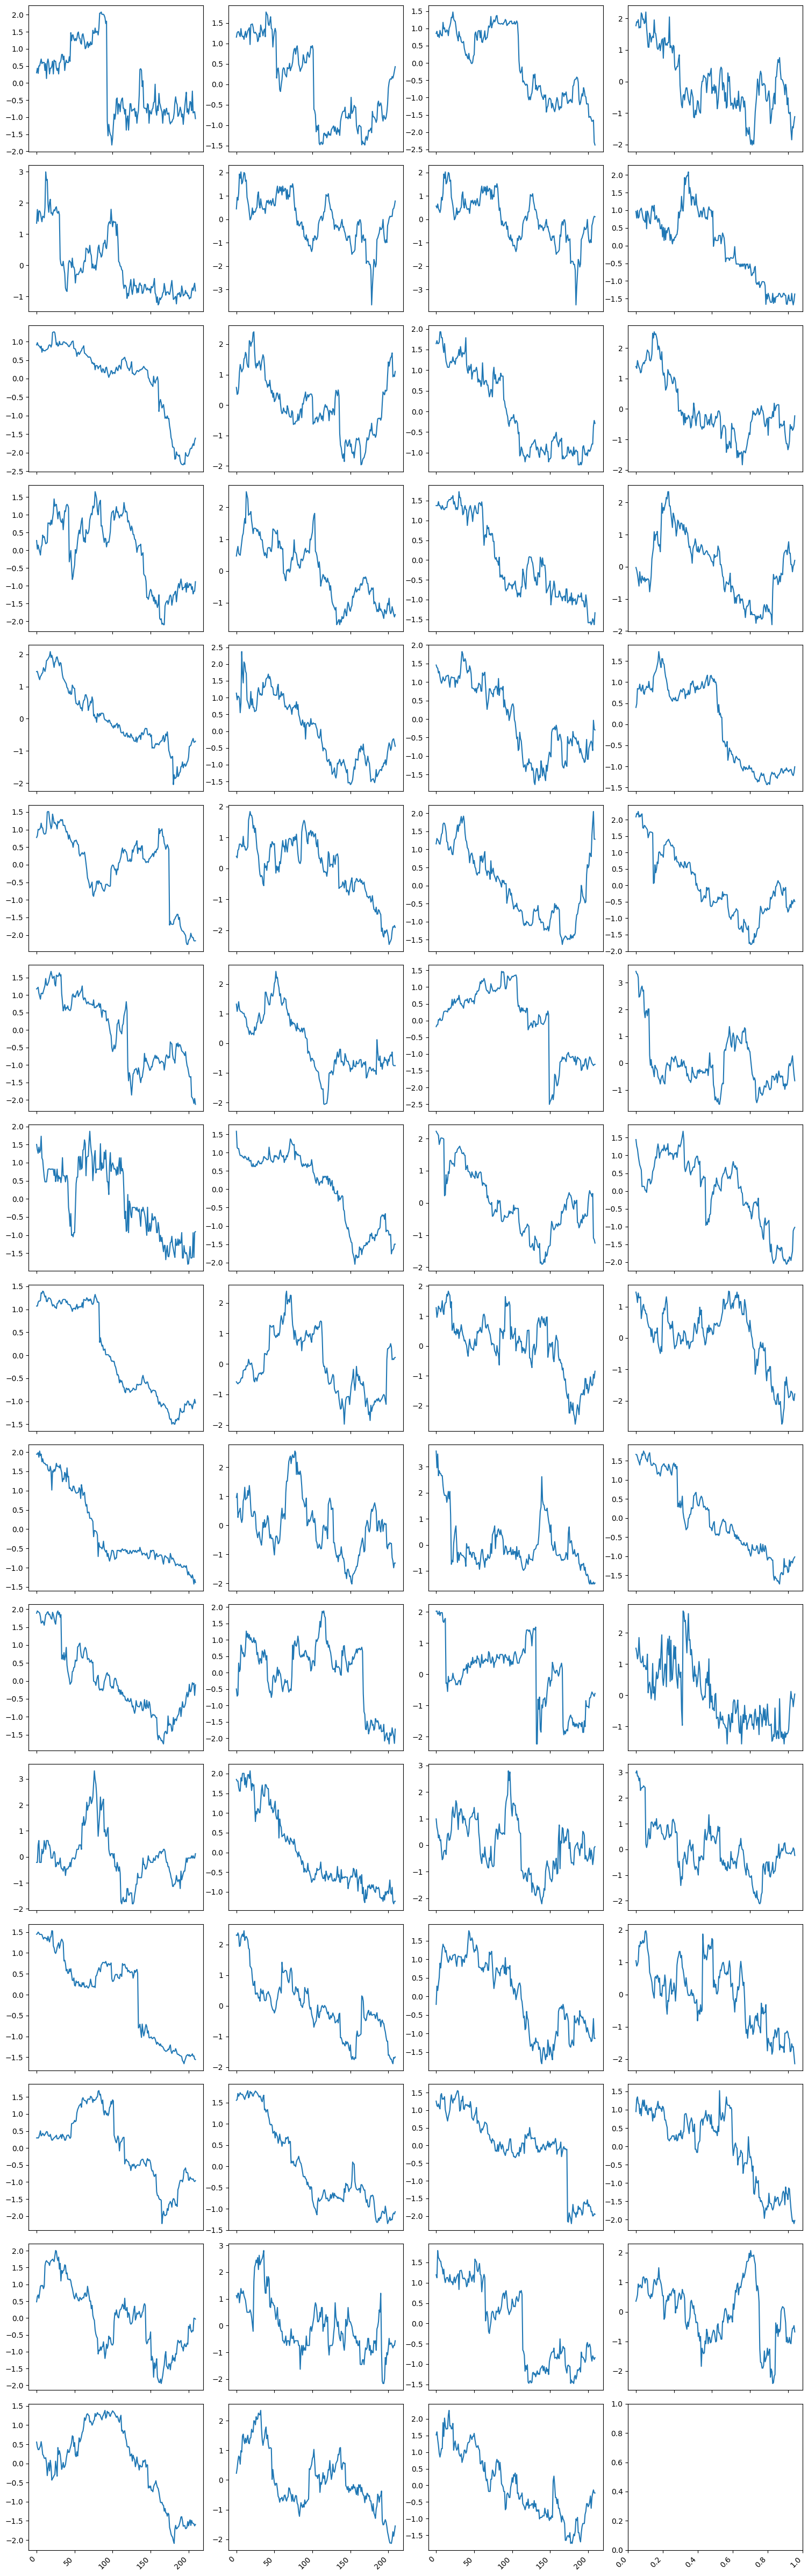

                          Cluster number: 1


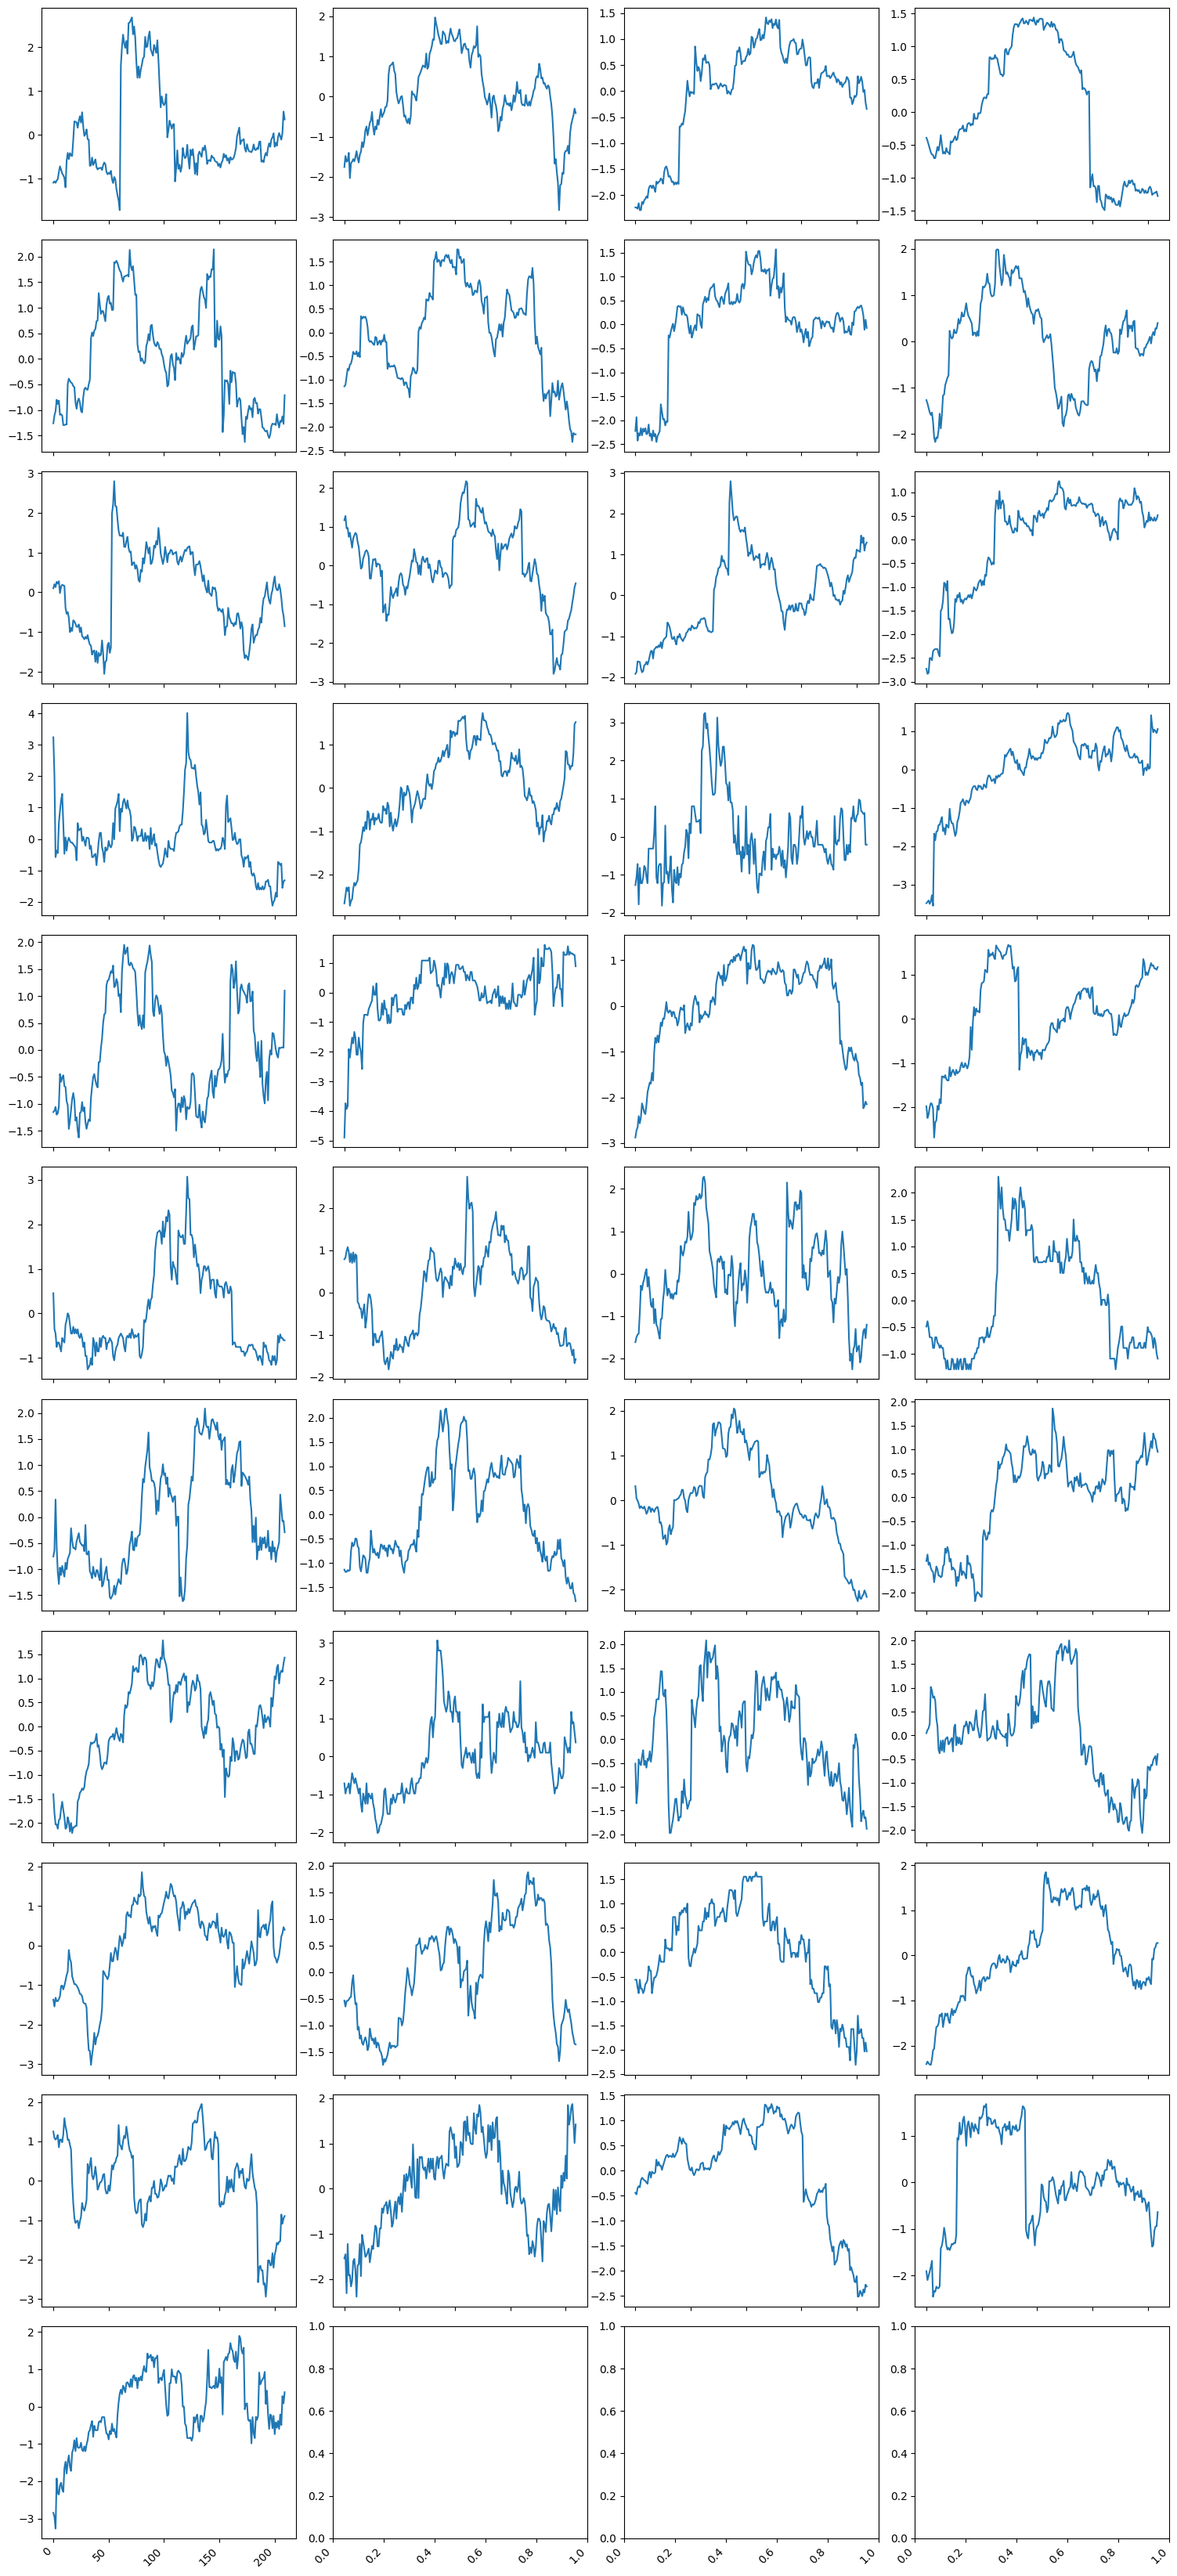

                          Cluster number: 2


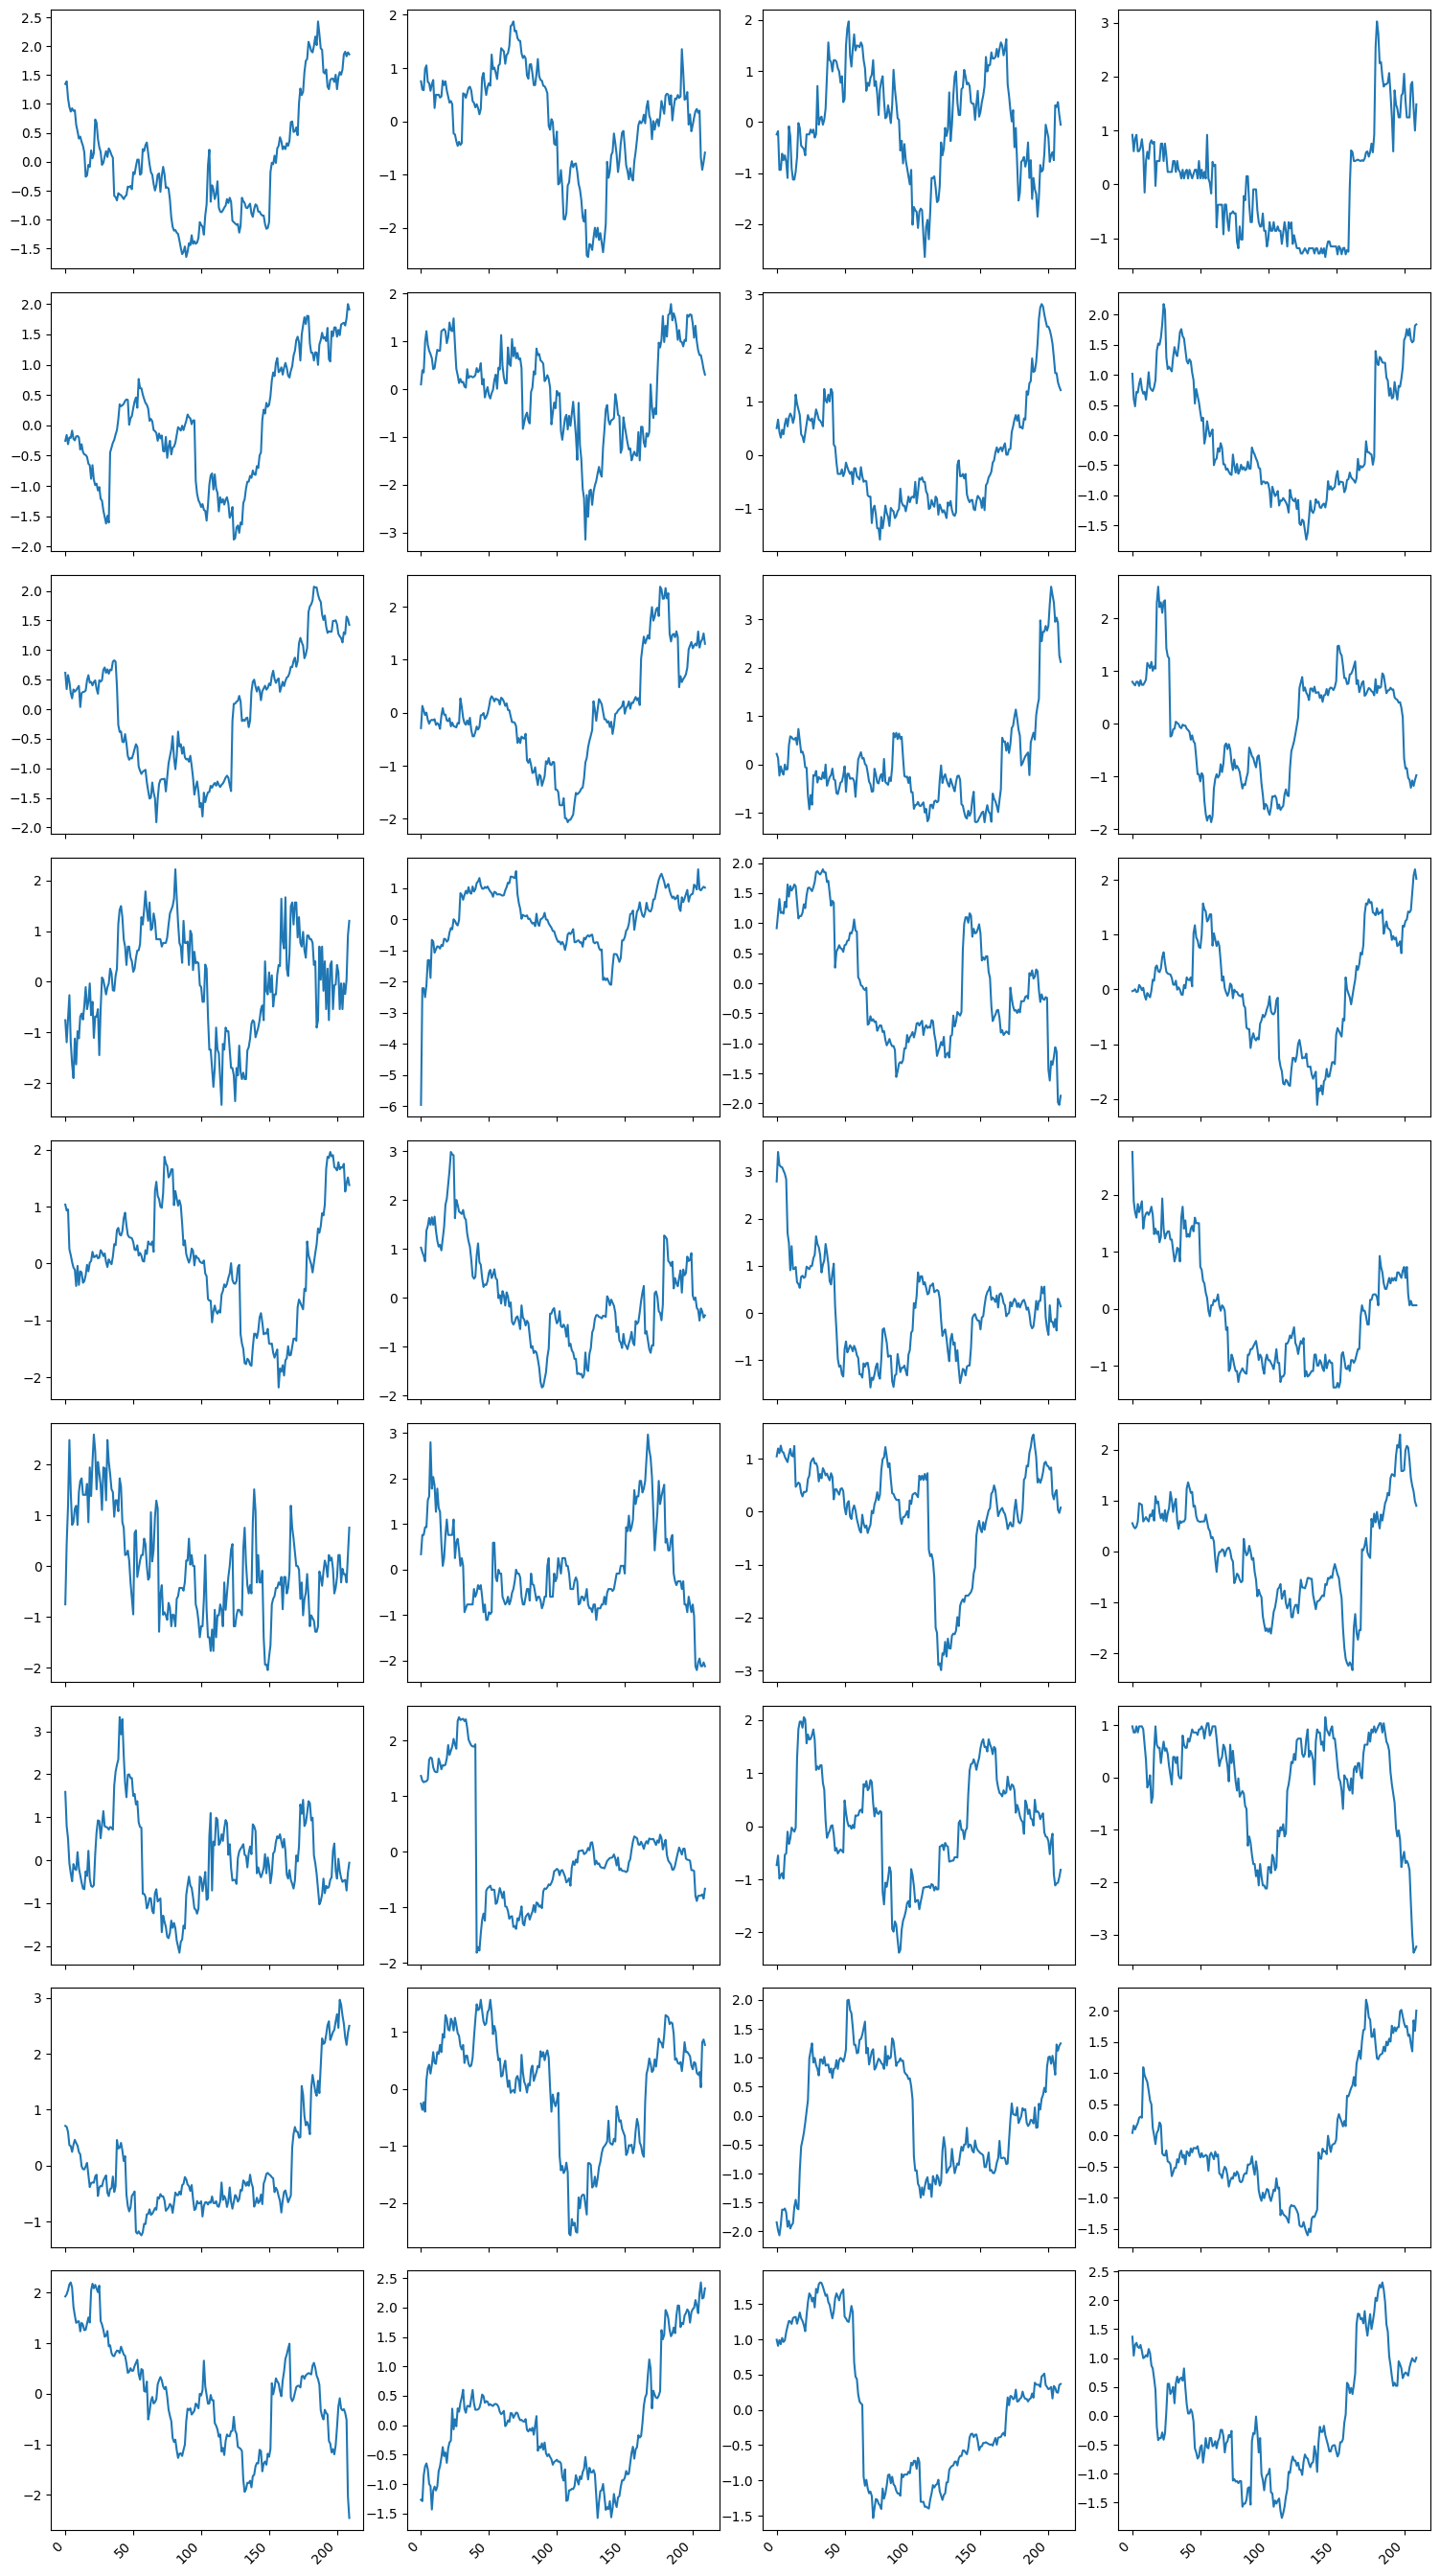

In [13]:
n_slice = 200
X_train_slice = X_train[:n_slice]
kmeans_cluster_slice = kmeans_cluster[:n_slice]
print_clusters(n_clusters, X_train_slice, kmeans_cluster_slice)

It looks pretty nice! Centroids do describe some patterns!

#### DTW Clustering

As we know `dtw` is computationally expensive. $n^2$ in time and $m^2$ in space, where n and m are ...

In [7]:
# take n random samples
n = 10000
X_subset = X_train.sample(n=n, random_state=42)

100%|██████████| 5/5 [2:57:04<00:00, 2124.93s/it]  


Text(0.5, 1.0, 'Elbow Method')

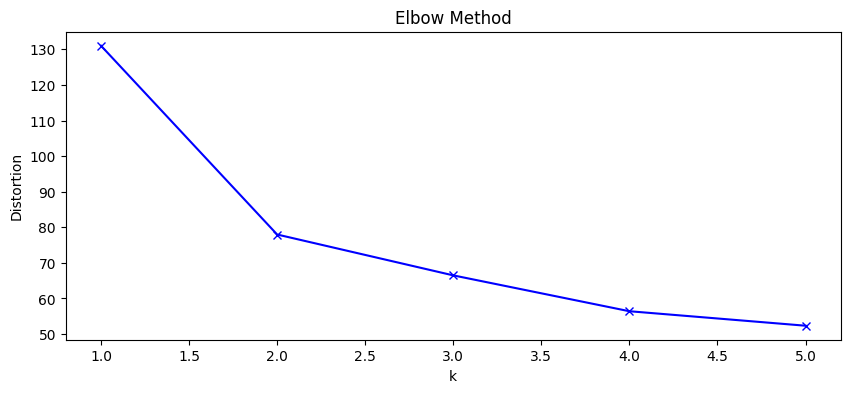

In [11]:
from tqdm import tqdm
distortions = []
K = range(1, 6)
for k in tqdm(K):
    kmeanModel = TimeSeriesKMeans(n_clusters=k, metric="dtw", n_jobs=3, max_iter=12, metric_params={"sakoe_chiba_radius": 10})
    kmeanModel.fit(X_subset)
    distortions.append(kmeanModel.inertia_)

plt.figure(figsize=(10,4))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('Elbow Method')

In [9]:
n_clusters = 3
ts_kmeans_dtw = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw", n_jobs=3, max_iter=12, metric_params={"sakoe_chiba_radius": 10})
ts_kmeans_dtw.fit(X_subset)

kmeans_cluster_dtw = ts_kmeans_dtw.predict(X_train)

/home/coder/.local/lib/rolos-python/site-packages/tslearn/utils/utils.py:90: UserWarning: 2-Dimensional data passed. Assuming these are 108298 1-dimensional timeseries
  warnings.warn(


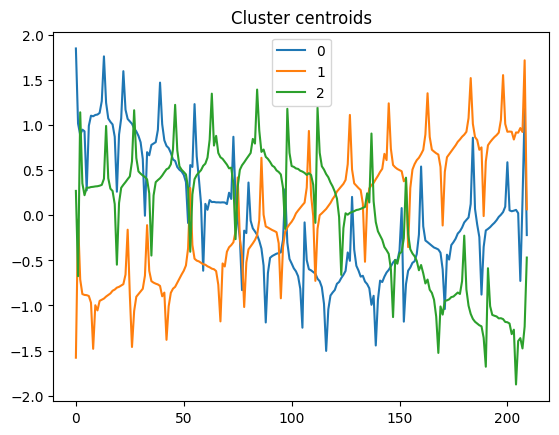

In [10]:
for cluster_number in range(n_clusters):
    plt.plot(ts_kmeans_dtw.cluster_centers_[cluster_number, :, 0].T, label=cluster_number)
plt.title("Cluster centroids")
plt.legend()

                          Cluster number: 0


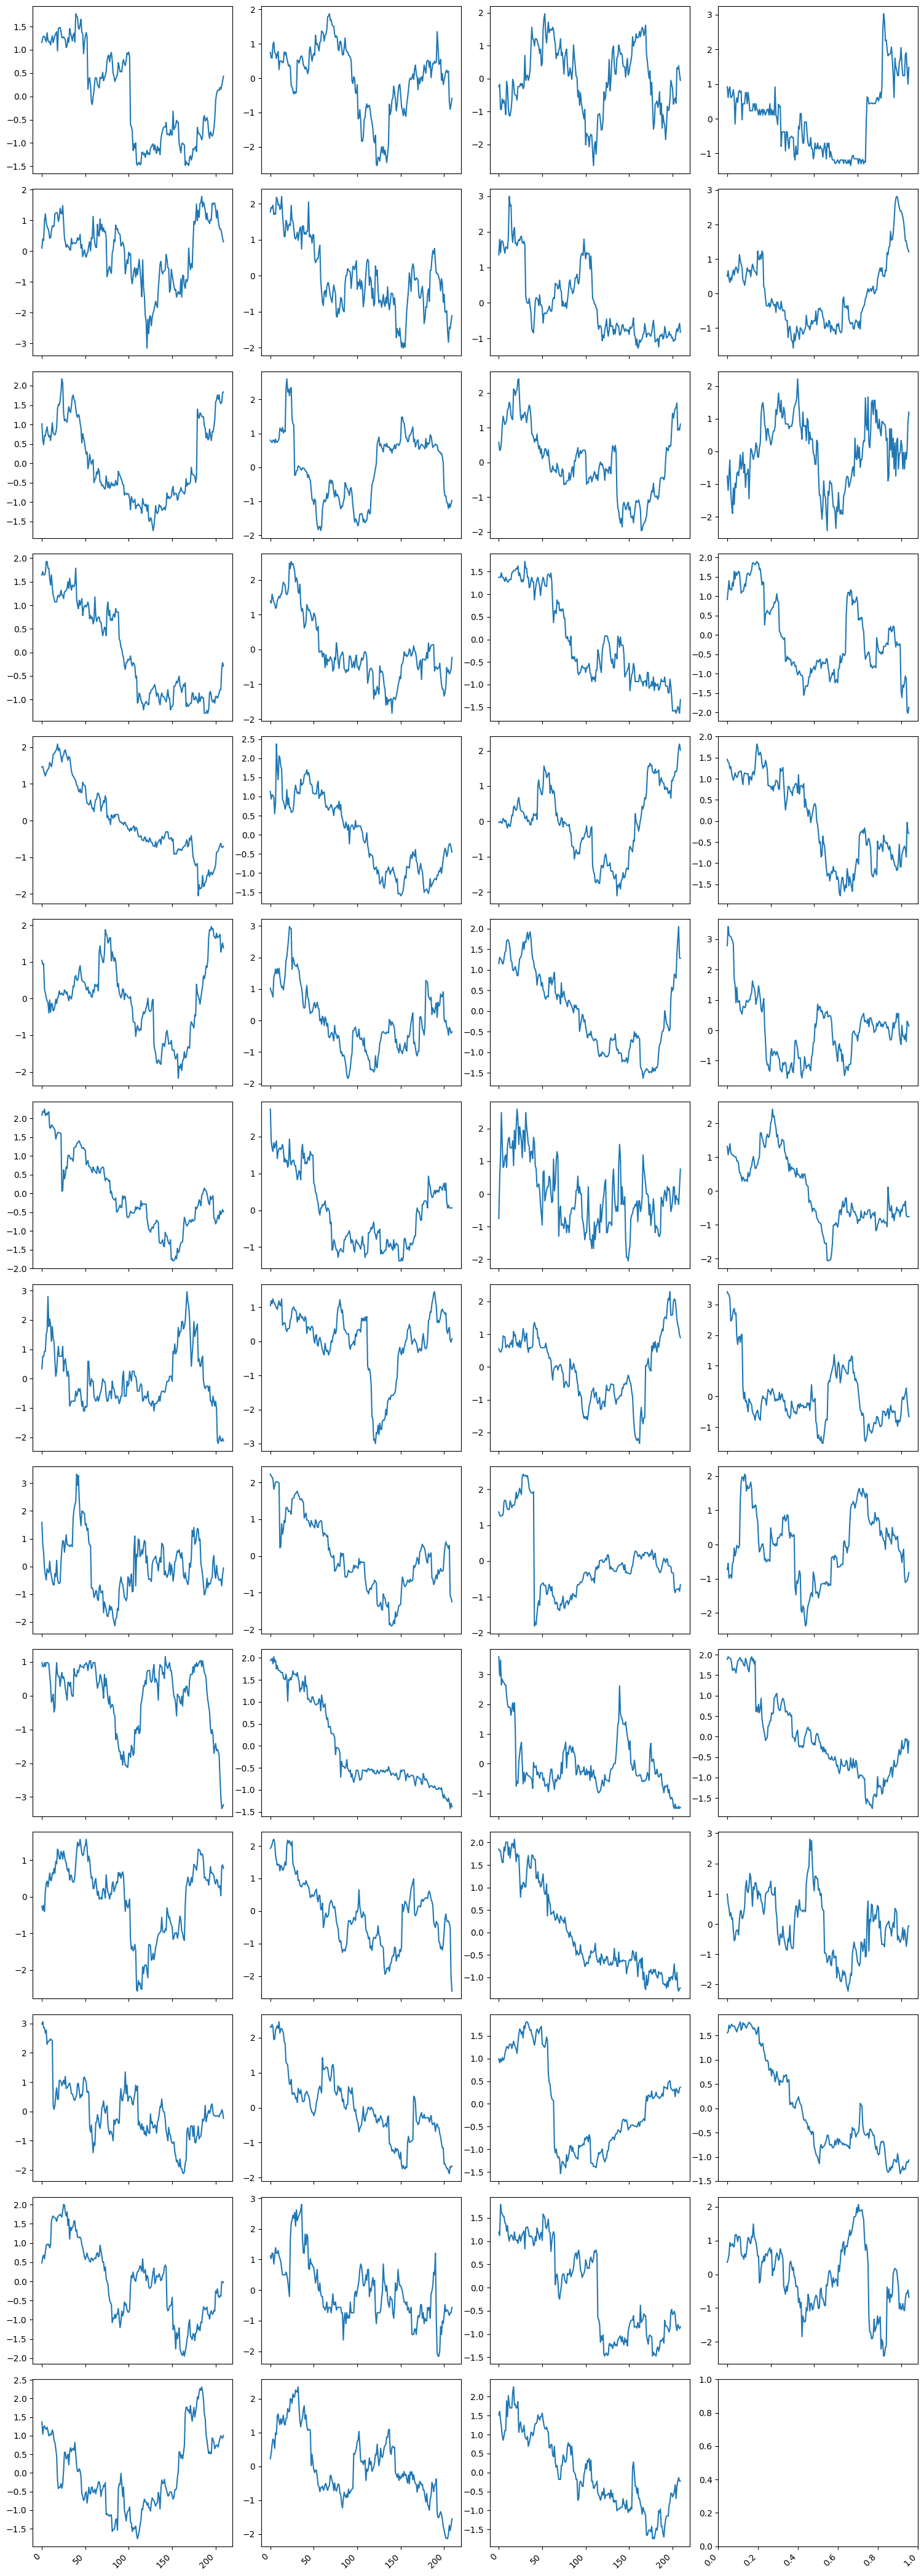

                          Cluster number: 1


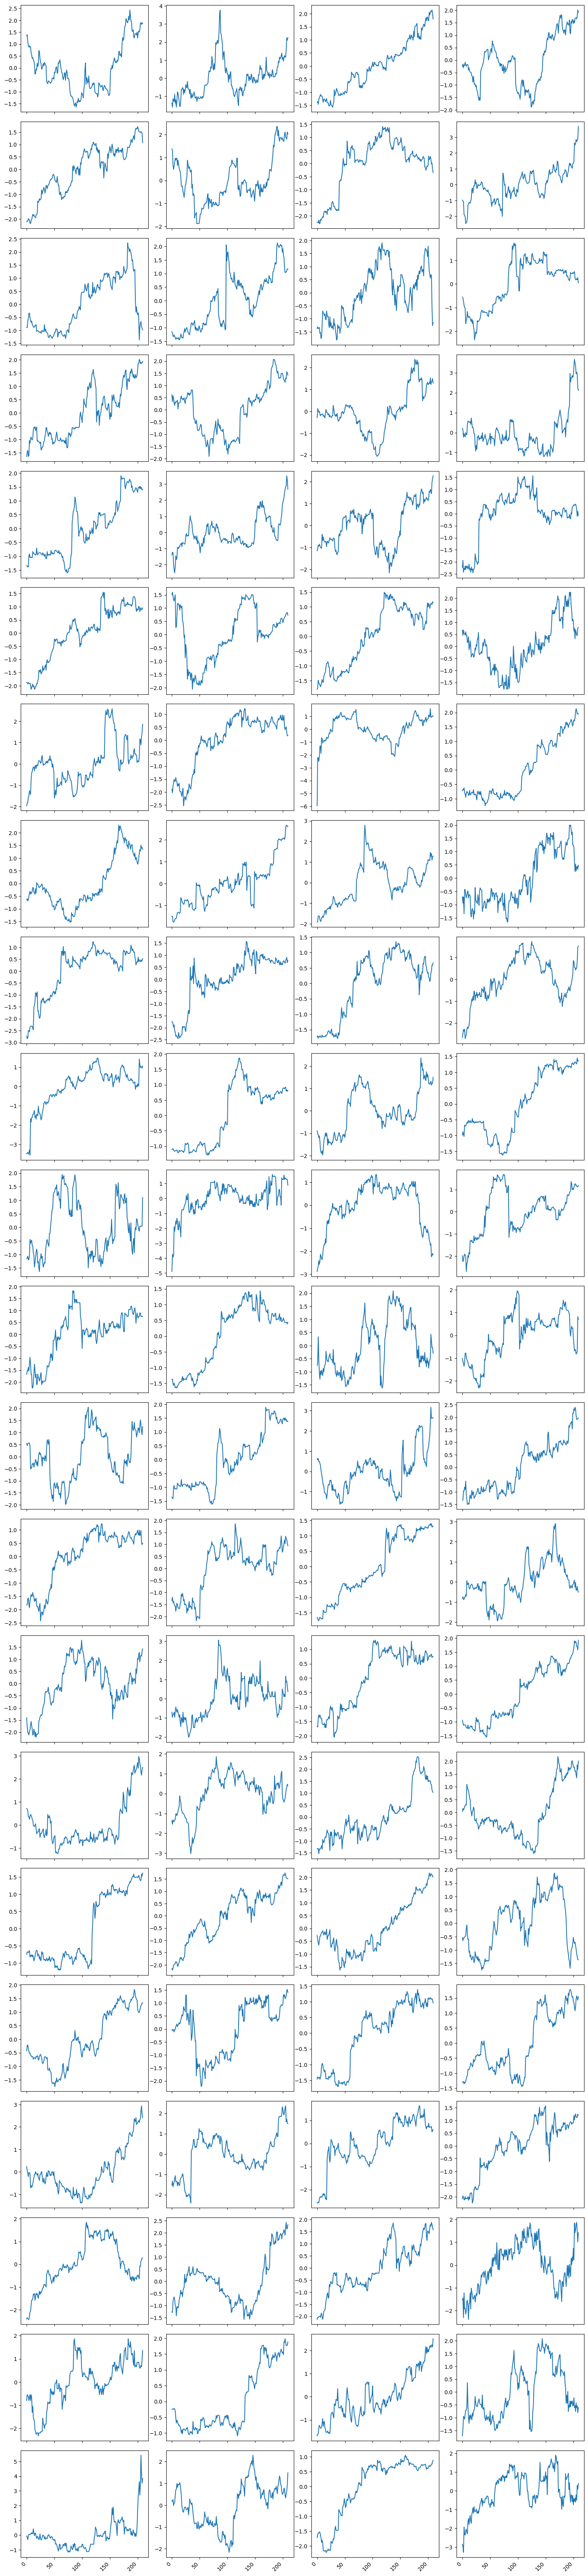

                          Cluster number: 2


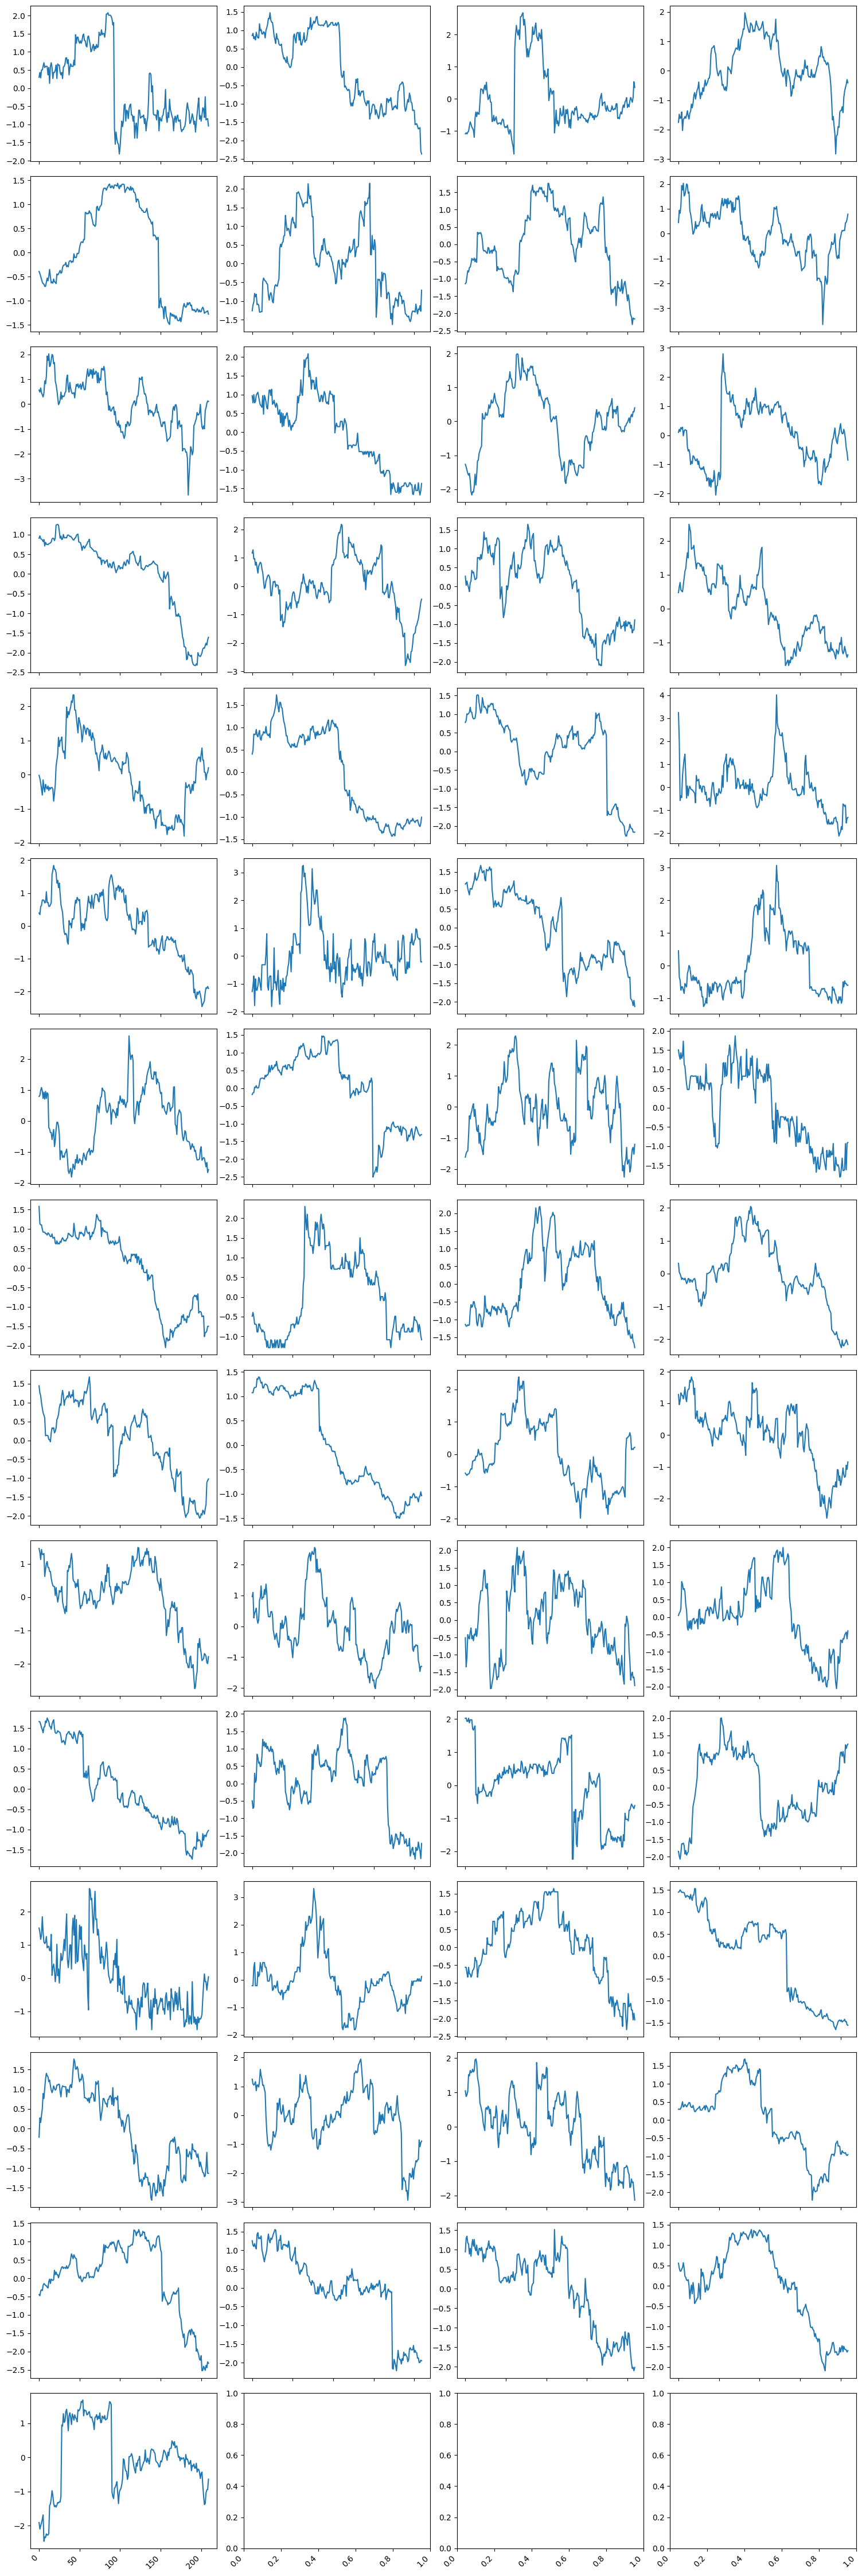

In [14]:
kmeans_cluster_dtw_slice = kmeans_cluster_dtw[:n_slice]
print_clusters(n_clusters, X_train_slice, kmeans_cluster_dtw_slice)

## Save the clusters

In [15]:
X_test = pd.read_csv(test_path)

kmeans_cluster_test = ts_kmeans.predict(X_test)
kmeans_cluster_dtw_test = ts_kmeans_dtw.predict(X_test)

/home/coder/.local/lib/rolos-python/site-packages/tslearn/utils/utils.py:90: UserWarning: 2-Dimensional data passed. Assuming these are 19112 1-dimensional timeseries
  warnings.warn(
/home/coder/.local/lib/rolos-python/site-packages/tslearn/utils/utils.py:90: UserWarning: 2-Dimensional data passed. Assuming these are 19112 1-dimensional timeseries
  warnings.warn(


In [16]:
cluster_feature_train = pd.DataFrame({"kmeans_cluster": kmeans_cluster, "kmeans_cluster_dtw": kmeans_cluster_dtw})
cluster_feature_test = pd.DataFrame({"kmeans_cluster": kmeans_cluster_test, "kmeans_cluster_dtw": kmeans_cluster_dtw_test})

In [17]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(sparse=False)
ohe.fit(cluster_feature_train)
cluster_feature_train_ohe = ohe.transform(cluster_feature_train)
cluster_feature_test_ohe = ohe.transform(cluster_feature_test)

/home/coder/.local/lib/rolos-python/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [18]:
cluster_feature_train_ohe = pd.DataFrame(cluster_feature_train_ohe, columns=[f"cluster_{i}" for i in range(cluster_feature_train_ohe.shape[1])])
cluster_feature_test_ohe = pd.DataFrame(cluster_feature_test_ohe, columns=[f"cluster_{i}" for i in range(cluster_feature_test_ohe.shape[1])])

cluster_feature_train_ohe.head(3)

cluster_0  cluster_1  cluster_2  cluster_3  cluster_4  cluster_5  cluster_6
0        1.0        0.0        0.0        0.0        0.0        0.0        1.0
1        0.0        0.0        1.0        0.0        0.0        1.0        0.0
2        1.0        0.0        0.0        0.0        1.0        0.0        0.0

In [19]:
cluster_feature_train_ohe.to_csv(os.path.join(data_dir, 'cluster_feature_train.csv'), index=False)
cluster_feature_test_ohe.to_csv(os.path.join(data_dir, 'cluster_feature_test.csv'), index=False)